# Download das bibliotecas

In [16]:
%pip install --upgrade pip
%pip install tensorflow
%pip install matplotlib
%pip install scipy
%pip install pandas
%pip install opencv_python
%pip install numpy
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2969 sha256=04b17da7574b1f05f318d2d9cea9ff5ac6cd1956ce1be6f34ceda72ac3398775
  Stored in directory: c:\users\ricardo\appdata\local\pip\cache\wheels\33\a3\d2\092b519e9522b4c91608b7dcec0dd9051fa1bff4c45f4502d1
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


# Treinamento do modelo

### Carregando o Dataset

In [4]:
import os

train_path = "../camera/personal/clean/75x75/train"
test_path  = "../camera/personal/clean/75x75/test"

classes = os.listdir(train_path)
classes = sorted(classes)
n_classes = len(classes)
print(f"Classes: {classes}")

input_shape = (75, 75, 3)  # InceptionV3 input size
file_count = []

for fld in os.listdir(train_path):
    crt = os.path.join(train_path, fld)
    image_count = len(os.listdir(crt))
    file_count.append(image_count)
    print(f'{crt} contains {image_count} images')

print(f'\nTotal number of images: {sum(file_count)}')

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
../camera/personal/clean/75x75/train\A contains 300 images
../camera/personal/clean/75x75/train\B contains 300 images
../camera/personal/clean/75x75/train\C contains 300 images
../camera/personal/clean/75x75/train\D contains 300 images
../camera/personal/clean/75x75/train\E contains 300 images
../camera/personal/clean/75x75/train\F contains 300 images
../camera/personal/clean/75x75/train\G contains 300 images
../camera/personal/clean/75x75/train\I contains 300 images
../camera/personal/clean/75x75/train\L contains 300 images
../camera/personal/clean/75x75/train\M contains 300 images
../camera/personal/clean/75x75/train\N contains 300 images
../camera/personal/clean/75x75/train\O contains 300 images
../camera/personal/clean/75x75/train\P contains 300 images
../camera/personal/clean/75x75/train\Q contains 300 images
../camera/personal/clean/75x75/train\R contains 300 images


### Criando Generators

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

# Define channel place
keras.backend.set_image_data_format('channels_last')

## Define constants
BATCH_SIZE = 32
SEED = 123

## Data augmentation and preprocessing
# Training Gen
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=input_shape[:2],
    shuffle=True,
    seed=SEED,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="training"
)

# Validation Gen
val_data_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input,
)

validation_generator = val_data_generator.flow_from_directory(
    train_path,
    target_size=input_shape[:2],
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="validation"
)

# Test Gen
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
test_generator = test_generator.flow_from_directory(
    test_path,
    target_size=input_shape[:2],
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

## Image quantity
train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

Found 5040 images belonging to 21 classes.
Found 1260 images belonging to 21 classes.
Found 4200 images belonging to 21 classes.


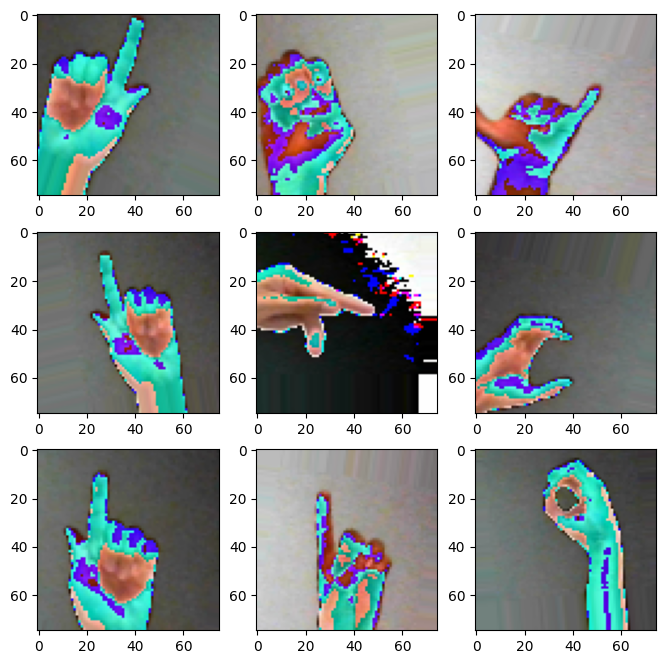

In [11]:
import matplotlib.pyplot as plt

# Visualize Examples
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

### Carregando o modelo

In [12]:
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# Load the InceptionV3 model with pre-trained weights (excluding top layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 37, 37, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 37, 37, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalization[0][0

### Compilando e treinando o modelo

In [13]:
EPOCHS = 50
filepath='./InceptionV3/'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=f'{filepath}keras_inceptionV3_model_weights_2.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f'{filepath}keras_inceptionV3_full_model_2.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1,
    ),
]

# Compiling Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_samples//BATCH_SIZE,
    callbacks = callbacks_list,
    validation_data=validation_generator,
    verbose = 1,
    validation_steps=validation_samples//BATCH_SIZE,
)

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.2123 - accuracy: 0.6653
Epoch 1: val_accuracy improved from -inf to 0.45513, saving model to ./InceptionV3\keras_inceptionV3_model_weights_2.h5

Epoch 1: val_loss improved from inf to 10.17995, saving model to ./InceptionV3\keras_inceptionV3_full_model_2.h5


c:\Users\Ricardo\Documents\GitHub\Pessoal\TCC\python-tcc\training\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 131s 744ms/step - loss: 1.2123 - accuracy: 0.6653 - val_loss: 10.1799 - val_accuracy: 0.4551
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.7997
Epoch 2: val_accuracy did not improve from 0.45513

Epoch 2: val_loss did not improve from 10.17995
157/157 [==============================] - 111s 707ms/step - loss: 0.7584 - accuracy: 0.7997 - val_loss: 1995.0419 - val_accuracy: 0.1298
Epoch 3/50
 84/157 [===============>..............] - ETA: 50s - loss: 0.3765 - accuracy: 0.8850

KeyboardInterrupt: 

# Testes

In [ ]:
import itertools
import pandas as pd
import numpy as np

def classification_report_csv(report):
  report_data = []
  lines = report.split('\n')
  for line in lines[2:-3]:
      row = {}
      row_data = [d for d in line.split(' ') if d!='']
      if (len(row_data) == 5):
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
  dataframe = pd.DataFrame.from_dict(report_data)
  dataframe.to_csv(f'{filepath}classification_report.csv', index = False)

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{filepath}confusion_matrix.png')

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()
plt.savefig(f'{filepath}training_curves.png')

In [ ]:
# Validation
score = model.evaluate(validation_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# test
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
report = classification_report(test_generator.classes, y_pred, target_names=target_names)
classification_report_csv(report)
print(report)